## 1. Setup and Imports

In [1]:
# --- standard libs ---
import sys
from pathlib import Path

# --- project root (for Jupyter) ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from prove_function import (
    plot_true_vs_estimated_trajectories, 
    compute_omat_per_timestep, 
    find_acoustic_position, 
    compute_position_error_noraml_acousitc
)

# Import acoustic model functions
from acoustic_function import (
    initialize_acoustic_model,
    simulate_trajectory,
    compute_observation_jacobian,
    observation_model,
    state_transition
)

# Import PFPF class
from pfpf_edh import PFPF_EDH
from ekf_ukf_pf.ekf import ExtendedKalmanFilter

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

# Get filter functions for EKF
state_transition_fn = state_transition # x_t = A * x_{t-1}
observation_fn = observation_model #  z_t = h(x_t) 
A = model_params["Phi"]
state_transition_jacobian_fn = lambda x: A # A
observation_jacobian_fn = compute_observation_jacobian

state_transition_fn = lambda x: state_transition(
    x, model_params, use_real_noise=False, no_noise=True
)

observation_fn = lambda x: observation_model(
    x, model_params, no_noise=True
)

state_transition_jacobian_fn = lambda x, u=None: model_params["Phi"]

observation_jacobian_fn = lambda x: compute_observation_jacobian(
    x, model_params
)

# Create EKF instance
ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model_params['Q'],
    R=model_params['R'],
    x0=model_params['x0_initial_target_states'],
    Sigma0=model_params['P0'] ,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn,
    use_joseph_form=True
)

## 3. Generate Ground Truth Data

In [3]:
# Generate ground truth trajectory and measurements
T = 20  # Number of time steps
print(f"Generating {T} time steps of data...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

Generating 20 time steps of data...


In [4]:
ground_truth_matlab = np.loadtxt('true_states_x_from_matlab.csv', delimiter=',')
measurements_matlab = np.loadtxt('true_states_measurements_from_matlab.csv', delimiter=',')
ground_truth_matlab = tf.convert_to_tensor(ground_truth_matlab, dtype=tf.float32)
measurements_matlab = tf.convert_to_tensor(measurements_matlab, dtype=tf.float32)


## 4. Create PFPF Filter

The PFPF class encapsulates all filter state and behavior:

In [5]:
pfpf_filter = PFPF_EDH(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    state_transition=state_transition,
    n_particle=500,
    n_lambda=29,
    lambda_ratio=1.2,
    use_local=False,
    use_ekf=True,
    ekf_filter=ekf,
    resample_threshold=1,
    verbose=True
)

## 5. Run PFPF Filter

In [6]:
estimates, particles_all, covariances_all, eff_all = pfpf_filter.run(measurements_matlab, model_params)


Running PFPF Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (EDH)
  EKF Covariance: Enabled
  Resample threshold: 1
  Time steps: 40
  Using provided EKF filter for covariance tracking
  Initialized uniform particle weights
  Initialized PFPF state variables

Processing time steps...
t 0
    Resampled (N_eff=129.2)
t 1
    Resampled (N_eff=167.2)
t 2
    Resampled (N_eff=23.3)
t 3
    Resampled (N_eff=39.8)
t 4
    Resampled (N_eff=7.4)
t 5
    Resampled (N_eff=8.3)
t 6
    Resampled (N_eff=1.0)
t 7
    Resampled (N_eff=1.0)
t 8
    Resampled (N_eff=5.4)
  Step 10/40
t 9
    Resampled (N_eff=11.0)
t 10
    Resampled (N_eff=3.4)
t 11
    Resampled (N_eff=17.2)
t 12
    Resampled (N_eff=6.5)
t 13
    Resampled (N_eff=52.4)
t 14
    Resampled (N_eff=1.1)
t 15
    Resampled (N_eff=4.0)
t 16
    Resampled (N_eff=52.0)
t 17
    Resampled (N_eff=17.8)
t 18
    Resampled (N_eff=36.1)
  Step 20/40
t 19
    Resampled (N_eff=52.8)
t 20
    Resampled (N_ef

## 6. Evaluate Performance

In [7]:
errors, mean_error = compute_position_error_noraml_acousitc(estimates, ground_truth_matlab, model_params['n_targets'])
rmse = tf.sqrt(tf.reduce_mean((estimates - ground_truth_matlab)**2))

print("="*70)
print("PERFORMANCE RESULTS")
print("="*70)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(mean_error).numpy():.4f} m")
print("Per-target average errors:")
for i in range(model_params['n_targets']):
    print(f"  Target {i+1}: {tf.reduce_mean(errors[i]).numpy():.4f} m")
print("="*70)

PERFORMANCE RESULTS
Overall RMSE: 0.6127 m
Mean position error (final): 1.2435 m
Mean position error (average): 0.6607 m
Per-target average errors:
  Target 1: 0.6100 m
  Target 2: 0.6797 m
  Target 3: 0.7675 m
  Target 4: 0.5855 m


In [8]:
estimates_position, ground_truth_position = find_acoustic_position(estimates, ground_truth_matlab)

Average OMAT error: 0.6607
Final OMAT error: 1.2435


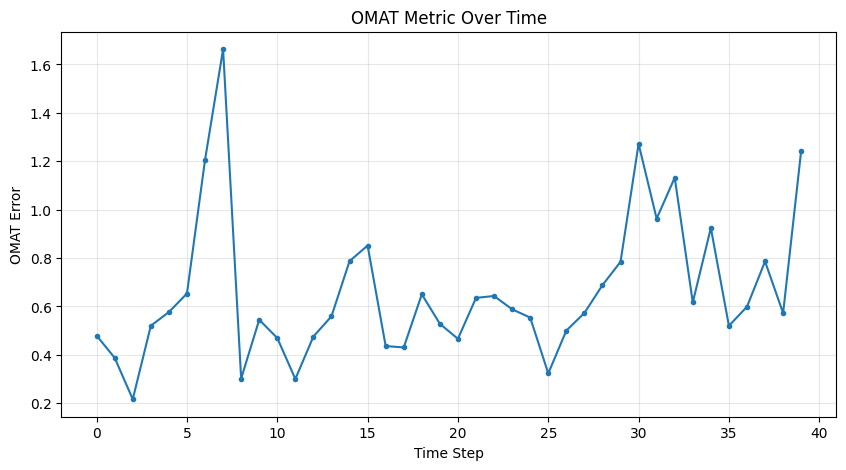

In [9]:
# Test with sample data
n_target = 2  # Each target has 2 state dimensions (e.g., x, y)
num_targets = 4  # Number of targets
omat_errors = compute_omat_per_timestep(ground_truth_position, estimates_position, num_targets, n_target, p = 1)

print(f"Average OMAT error: {tf.reduce_mean(omat_errors):.4f}")
print(f"Final OMAT error: {omat_errors[-1]:.4f}")
# Plot OMAT over time
plt.figure(figsize=(10, 5))
plt.plot(omat_errors.numpy(), marker='o', markersize=3)
plt.xlabel('Time Step')
plt.ylabel('OMAT Error')
plt.title('OMAT Metric Over Time')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Access Filter State

In [10]:
print("Final filter state:")
print(f"  Particles: {pfpf_filter.particles.shape}")
print(f"  Weights sum: {tf.reduce_sum(pfpf_filter.weights).numpy():.6f}")
print(f"  Mean estimate: {pfpf_filter.particles_mean.shape}")
print(f"  Covariance P: {pfpf_filter.P.shape}")
print(" vg dictionary → PFPF class mapping:")
print(f"  vg['particles']   → self.particles")
print(f"  vg['logW']        → self.log_weights")
print(f"  vg['ml_weights']  → self.weights")
print(f"  vg['particles_m'] → self.particles_mean")

Final filter state:
  Particles: (16, 500)
  Weights sum: 1.000000
  Mean estimate: (16,)
  Covariance P: (16, 16)
 vg dictionary → PFPF class mapping:
  vg['particles']   → self.particles
  vg['logW']        → self.log_weights
  vg['ml_weights']  → self.weights
  vg['particles_m'] → self.particles_mean


## 8. Visualize Results

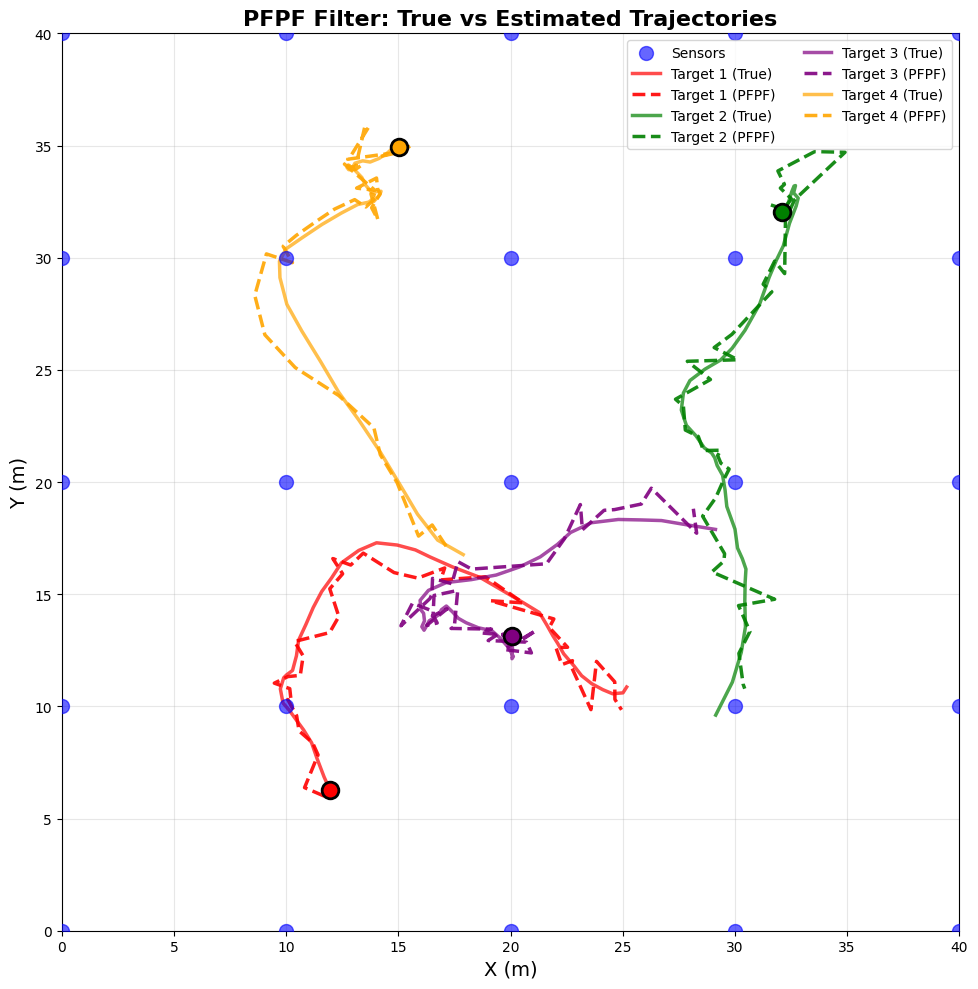

In [11]:
plot_true_vs_estimated_trajectories(
    model_params,
    ground_truth_matlab,
    estimates,
    title="PFPF Filter: True vs Estimated Trajectories",
    estimate_label="PFPF",
    figsize=(12, 10),
    colors=None
)